In [1]:
from sogym.env import sogym
from sogym.utils import FigureRecorderCallback
import numpy as np
import stable_baselines3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize, SubprocVecEnv
import torch
from stable_baselines3 import PPO
from sogym.mmc_optim import run_mmc
%load_ext autoreload
%autoreload 2

print('SB3 version:', stable_baselines3.__version__)
# Let's make the code device agnostic:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

SB3 version: 1.7.0
Using device: cpu


---
### Environment test and visualization:

In [3]:
from stable_baselines3.common.env_checker import check_env
# It will check your custom environment and output additional warnings if needed
check_env(sogym(mode='train',observation_type='dense'))

In [3]:
# Let's test the environment using the check_env util from SB3:
train_env = sogym(mode='train',observation_type='dense',vol_constraint_type='hard')
eval_env = sogym(mode='test',observation_type='dense',vol_constraint_type='hard')
obs = train_env.reset()

In [ ]:
# Let's visualize the training environment on a random problem statement and visualize a 'successful' solution:
reward = 0.0
while reward==0.0:
    obs = train_env.reset()
    done = False
    while not done:
        action = train_env.action_space.sample()
        obs, reward, done, info = train_env.step(action)
print("Volume: ", train_env.volume)
print("Reward ",reward)

train_env.plot()

Volume:  0.4979757553332994
Reward  0.0


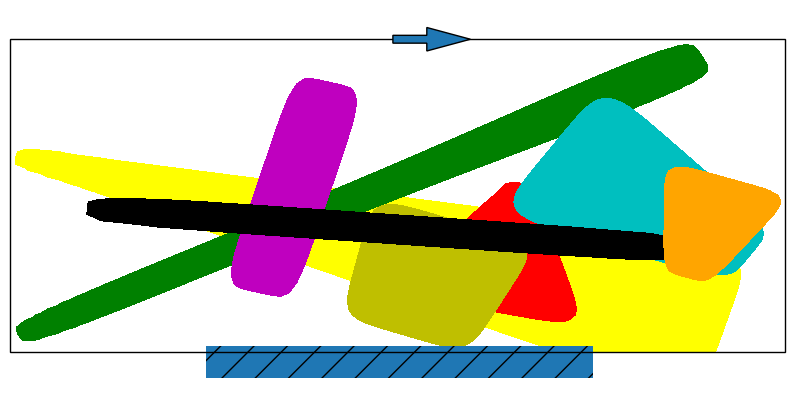

In [ ]:
# Let's visualize the eval environment:
obs = eval_env.reset()
done = False
while not done:
    action = eval_env.action_space.sample()
    obs, reward, done, info = eval_env.step(action)
print("Volume: ", eval_env.volume)
print("Reward ",reward)
eval_env.plot()

---
### Multiprocessing

In [2]:
from transformers import AutoTokenizer, AutoModel
#tokenizer = AutoTokenizer.from_pretrained("huggingface/CodeBERTa-small-v1")
#model = AutoModel.from_pretrained("huggingface/CodeBERTa-small-v1").to('cuda')
num_cpu = 6 # Number of processes to use
train_env = sogym(mode='train',observation_type='box_dense',vol_constraint_type = 'soft',model=model,tokenizer=tokenizer)
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
#env=VecNormalize(env,gamma=1.0)

eval_env = sogym(mode='test',observation_type='box_dense',vol_constraint_type='soft',model=model,tokenizer=tokenizer)
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
#eval_env =VecNormalize(eval_env,gamma=1.0)


Some weights of the model checkpoint at huggingface/CodeBERTa-small-v1 were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# Let's  test that an eval callback actually works:
from stable_baselines3.common.callbacks import EvalCallback, CallbackList

eval_callback = EvalCallback(eval_env,log_path='tb_logs',eval_freq=100,deterministic=True,render=False,verbose=0)
callback = CallbackList([eval_callback,
                         FigureRecorderCallback(check_freq=2*8*32)])

--- 
### Defining the model

In [4]:
from sogym.utils import ImageDictExtractor
policy_kwargs = dict(
    #features_extractor_class=ImageDictExtractor,
    net_arch=dict(pi=[512,512,512], vf=[512,512,512]),
               #optimizer_kwargs={"weight_decay": 1e-3},
)

In [5]:
model = PPO("MultiInputPolicy",
            env,
            #seed=42,
            #policy_kwargs = policy_kwargs,
            n_steps=512//num_cpu,#(2048*16)//32,  #def: 224
            batch_size=512,#2048*2, #def: 50*224
            verbose=0,
            n_epochs=3,
            vf_coef = 1.0,
            clip_range = 0.3,
            clip_range_vf = 10.0,
            #target_kl = 0.02,
            gamma=1.0,  #def: 1
            learning_rate=3e-4,
            ent_coef=3e-4,
            tensorboard_log="tb_logs",
            device='cuda'
            )


/home/thomas/anaconda3/envs/SB3_update/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:145: UserWarning: You have specified a mini-batch size of 512, but because the `RolloutBuffer` is of size `n_steps * n_envs = 510`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 510
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=85 and n_envs=6)
  warnings.warn(


--- 
### Training

In [ ]:

model.learn(10000000,callback=callback,tb_log_name='test_v2_with_text')
#model.save('model_saved',)
#env.save('env_saved.pkl')

In [36]:
num_cpu = 32 # Number of processes to use
train_env = sogym(mode='train',observation_type='dense',vol_constraint_type= 'soft')
env= make_vec_env(lambda:train_env, n_envs=num_cpu,vec_env_cls=SubprocVecEnv)
env = VecNormalize.load('env_saved.pkl',env)

eval_env = sogym(mode='test',observation_type='dense',vol_constraint_type='soft')
eval_env = make_vec_env(lambda:eval_env, n_envs=1,vec_env_cls=SubprocVecEnv)
eval_env = VecNormalize.load('env_saved.pkl',eval_env)

model.load('model_saved',env=env,device='cuda')
model.learn(5000000,callback=callback,reset_num_timesteps=False,tb_log_name='test_again')

In [37]:
model.save('model_saved',)
env.save('env_saved.pkl')

---
### Let's visualize the agent's performance:

In [43]:
env=sogym(mode='train',observation_type='dense',vol_constraint_type='soft' )
#env= make_vec_env(lambda:env, n_envs=1,vec_env_cls=SubprocVecEnv)
env

In [ ]:
obs=env.reset()
dones=False

while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones, info = env.step(action)
    
env.plot()

In [ ]:
obs=env.reset()
dones=False

while dones== False:
    action, _states = model.predict(obs,deterministic=True)
    print(action)
    obs, rewards, dones, info = env.step(action)
  
print("Reward:",rewards[0])
#print("Volume:",np.round(env.get_attr('volume')[0]*100,2),"%")
fig=env.env_method('plot')[0]
fig = env.render()

fig